In [20]:
from datetime import date
import datetime 
import shutil
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import openpyxl


def move_download(TICKER):
    source = f'C:/Users/joaom/Downloads/{TICKER}.csv'
    destination = 'C:/Users/joaom/OneDrive/Documentos/GitHub/Snp1000/Performance Tables'
    dest = shutil.move(source, destination) 

companies = pd.read_csv('03_Tables/SnP1000_TICKR.csv')
companies_list = companies['Companie'].to_list()
df = pd.DataFrame()

today = date.today()
current_day = int(today.strftime('%d'))
current_month = int(today.strftime('%m'))
current_year = int('20'+today.strftime('%y'))

start = datetime.date(2020,10,19)
end = datetime.date(current_year,current_month,current_day)

#Module 1 - Get data
companies_list=['TSLA']
for i in companies_list[:1]:
    print(str(companies_list.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)
    try:
        stock = []
        stock = yf.download(i, start=start, end=end, progress=False)
        if len(stock) == 0:
            None
        else:
            stock['Name'] = i
            df = df.append(stock, sort=False)
    except Exception:
        None


0 : TSLA,

In [21]:
#Module 2 - Calculate RSI (relative Strength Index)
#df = df.iloc[-60:] # Get just about the last two months of data

df.reset_index(inplace=True)
df['Change'] = (df['Close'].shift(-1)-df['Close']).shift(1)
df['ChangeAverage'] = df['Change'].rolling(window=2).mean()
df['ChangeAverage+'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] > 0 else 0,axis=1).rolling(window=14).mean()
df['ChangeAverage-'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] < 0 else 0,axis=1).rolling(window=14).mean()*-1
df['RSI'] = 100-(100/(1+(df['ChangeAverage+']/df['ChangeAverage-'])))
df = df.drop(columns = ['ChangeAverage','ChangeAverage','ChangeAverage'])


In [22]:
#Module 3 - Calculate OBV (On Balance Volume) 
VolumeList = df['Volume'].tolist()
OBV = [VolumeList[0]]
i=1
for i in range(1,len(VolumeList)):
    #i=i+1
    if VolumeList[i] > VolumeList[i-1]:
        OBV.append(OBV[i-1]+VolumeList[i])
        continue
    if VolumeList[i]==VolumeList[i-1]:
        OBV.append(OBV[i-1]+0)
        continue
    if VolumeList[i]<VolumeList[i-1]:
        OBV.append(OBV[i-1]-VolumeList[i])
        continue  
df['OBV'] = OBV

#Module 4 - Calculate Linear Regressions on Close and OBV plus errors

delay=5 # How many trading days to calculate moving slopes

OBV_regression = [0 for x in range(delay)]
OBV_regression_err = [0 for x in range(delay)]
Close_regression = [0 for x in range(delay)]
Close_regression_err = [0 for x in range(delay)]

Date = df['Date'].tolist()
x = np.array([x for x in range(delay)])
for i in range(delay,len(OBV)):
    y = df['OBV'].iloc[i-delay:i].values
    y2 = df['Close'].iloc[i-delay:i].values
    slope, intercept, r_value, p_value, err = stats.linregress(x,y)
    slope2, intercept2, r_value2, p_value2, err2 = stats.linregress(x,y2)
    #value = LinearRegression().fit(x,y).coef_[0]
    OBV_regression.append(slope)
    OBV_regression_err.append(err)
    Close_regression.append(slope2)
    Close_regression_err.append(err2)

df['OBV_Regression'] = OBV_regression
df['OBV_Regression_err'] = OBV_regression_err
df['Close_Regression'] = Close_regression
df['Close_Regression_err'] = Close_regression_err


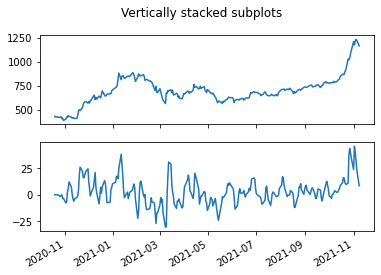

In [23]:
from matplotlib.dates import DateFormatter

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')

axs[0].plot(df['Date'], df['Close'])
axs[1].plot(df['Date'], df['Close_Regression'])

fig.autofmt_xdate()
plt.show()

In [25]:
#Export to Excel (clean excel sheet initially to always paste correctly)
filename = 'output1.xlsx'
df.to_excel(filename)
print('DataFrame is written successfully to Excel Sheet.')

DataFrame is written successfully to Excel Sheet.


In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Change,ChangeAverage+,ChangeAverage-,RSI,OBV,OBV_Regression,OBV_Regression_err,Close_Regression,Close_Regression_err
0,2021-08-16,705.070007,709.500000,676.400024,686.169983,686.169983,22677400,TSLA,NaN,NaN,NaN,NaN,22677400,0.0,0.000000e+00,0.000000,0.000000
1,2021-08-17,672.659973,674.580017,648.840027,665.710022,665.710022,23721300,TSLA,-20.459961,NaN,NaN,NaN,46398700,0.0,0.000000e+00,0.000000,0.000000
2,2021-08-18,669.750000,695.770020,669.349976,688.989990,688.989990,20349400,TSLA,23.279968,NaN,NaN,NaN,26049300,0.0,0.000000e+00,0.000000,0.000000
3,2021-08-19,678.210022,686.549988,667.590027,673.469971,673.469971,14313500,TSLA,-15.520020,NaN,NaN,NaN,11735800,0.0,0.000000e+00,0.000000,0.000000
4,2021-08-20,682.849976,692.130005,673.700012,680.260010,680.260010,14781800,TSLA,6.790039,NaN,NaN,NaN,26517600,0.0,0.000000e+00,0.000000,0.000000
5,2021-08-23,685.440002,712.130005,680.750000,706.299988,706.299988,20264900,TSLA,26.039978,NaN,NaN,NaN,46782500,-2698250.0,4.304244e+06,-0.406000,3.456012
6,2021-08-24,710.679993,715.219971,702.640015,708.489990,708.489990,13083100,TSLA,2.190002,NaN,NaN,NaN,33699400,123590.0,5.478842e+06,7.244995,3.877833
7,2021-08-25,707.030029,716.969971,704.000000,711.200012,711.200012,12645600,TSLA,2.710022,NaN,NaN,NaN,21053800,5034690.0,3.641121e+06,7.183002,3.870675
8,2021-08-26,708.309998,715.400024,697.619995,701.159973,701.159973,13214300,TSLA,-10.040039,NaN,NaN,NaN,34268100,2581780.0,4.595549e+06,10.369006,2.403476
9,2021-08-27,705.000000,715.000000,702.099976,711.919983,711.919983,13762100,TSLA,10.760010,NaN,NaN,NaN,48030200,-1022770.0,3.487560e+06,4.669995,3.647614
